## Importing

In [66]:
#!/usr/bin/env python

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
import pandas
import certifi
import json
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
import csv
import os
import ast
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree, metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


# Creating Data Frames

#### Observed stocks:

In [2]:
stock_list = ['DIS','T','NFLX','AMZN','BBY','CMG','KO','CL','COST','EQT','CVX','XOM','JPM','AXP','BAC','CVS','TECH','JNJ','BA','FDX','GE','AAPL','IBM','INTC','AMCR','ECL','NEM','IRM','AMT','EQIX','EXC','NRG','EIX']

#### Selected Sector's Stocks (Energy):

In [5]:
energy_stocks = ['APA','BKR','CVX','COP','CTRA','DVN','FANG','EOG','EQT','XOM','HAL','HES','KMI','MRO','MPC','OXY','OKE','PSX','PXD','SLB','TRGP','VLO','WMB']

#### Creating json daily files:

In [ ]:
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

for i in stock_list:
    url = ("https://financialmodelingprep.com/api/v3/historical-price-full/{}?apikey=2f1c3c73de79230c2b4b038861ddf970".format(i))
    j = get_jsonparsed_data(url)
    df = pd.DataFrame(j['historical'])
    stock_name = j['symbol']
    df.to_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_daily/Observed/{}.csv'.format(stock_name), index=False)
    
for i in energy_stocks:
    url = ("https://financialmodelingprep.com/api/v3/historical-price-full/{}?apikey=2f1c3c73de79230c2b4b038861ddf970".format(i))
    j = get_jsonparsed_data(url)
    df = pd.DataFrame(j['historical'])
    stock_name = j['symbol']
    df.to_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_daily/Energy Sector/{}.csv'.format(stock_name), index=False)

#### Creating json hourly files:

In [ ]:
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

for i in stock_list:
    url = ("https://financialmodelingprep.com/api/v3/historical-chart/1hour/{}?apikey=2f1c3c73de79230c2b4b038861ddf970".format(i))
    j = get_jsonparsed_data(url)
    df = pd.DataFrame(j)
    stock_name = i
    df.to_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_hourly/Observed/{}.csv'.format(stock_name), index=False)
    
for i in energy_stocks:
    url = ("https://financialmodelingprep.com/api/v3/historical-price-full/{}?apikey=2f1c3c73de79230c2b4b038861ddf970".format(i))
    j = get_jsonparsed_data(url)
    df = pd.DataFrame(j['historical'])
    stock_name = j['symbol']
    df.to_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_hourly/Energy Sector/{}.csv'.format(stock_name), index=False)

# Initial Observation

First of all, we'd like to see how different features distribute, how they correlate with each other and also find out more statistic information about them 

For now we'll focus on Apple stock

#### Raw Data

In [150]:
df= pd.read_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_daily/Observed/AAPL.csv')
df.head()

date     open    high     low   close    adjClose     volume   
0  2023-05-08  172.480  173.82  172.11  173.23  173.230000   20870258  \
1  2023-05-05  170.975  174.30  170.76  173.57  173.570007  112900196   
2  2023-05-04  164.890  167.04  164.31  165.79  165.789993   81225673   
3  2023-05-03  169.500  170.92  167.16  167.45  167.449997   65126998   
4  2023-05-02  170.090  170.35  167.54  168.54  168.539993   48425696   

   unadjustedVolume  change  changePercent    vwap       label  changeOverTime  
0          20870258   0.750       0.434833  173.05  May 08, 23        0.004348  
1         109452410   2.595       1.520000  173.31  May 05, 23        0.015200  
2          81235400   0.900       0.545820  166.10  May 04, 23        0.005458  
3          65136000  -2.050      -1.210000  169.01  May 03, 23       -0.012100  
4          48425700  -1.550      -0.911280  168.70  May 02, 23       -0.009113

The features in the data are:
- Date: A string containing the observation's date.
- Open: The opening price of the stock on the date of the observation.
- High: The highest price the stock had on the trading day of the observation.
- Low: The lowest price the stock had on the trading day of the observation.
- Close: The closing price of the stock on the date of the observation.
- AdjClose: The closing price of the stock on the date of the observation after dividends.
- Volume: Number of stocks being traded on the day of the observation.
- UnAdjustedVolume: Same as Volume, but without any adjustments.
- Change: The difference between the open and close.
- ChangePercent: Same as change but in percentages.
- VWAP: VWAP stands for Volume-Weighted Average Price of the stock in the observation. 
- Label: The date of the observation as a different string then the "Date" feature.
- ChangeOverTime: "ChangePercent" divided by 100.

### Visualization

##### Viewing the whole data at once

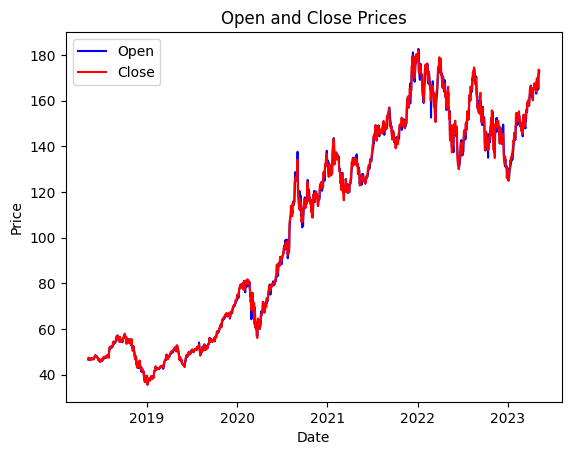

In [151]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Set up the figure and axis
fig, ax = plt.subplots()

# Plot 'open' and 'close' prices
ax.plot(df['date'], df['open'], color='blue', label='Open')
ax.plot(df['date'], df['close'], color='red', label='Close')

# Set the title and axis labels
ax.set_title('Open and Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Add a legend
ax.legend()

# Display the plot
plt.show()

##### Viewing each month separately for better viewing

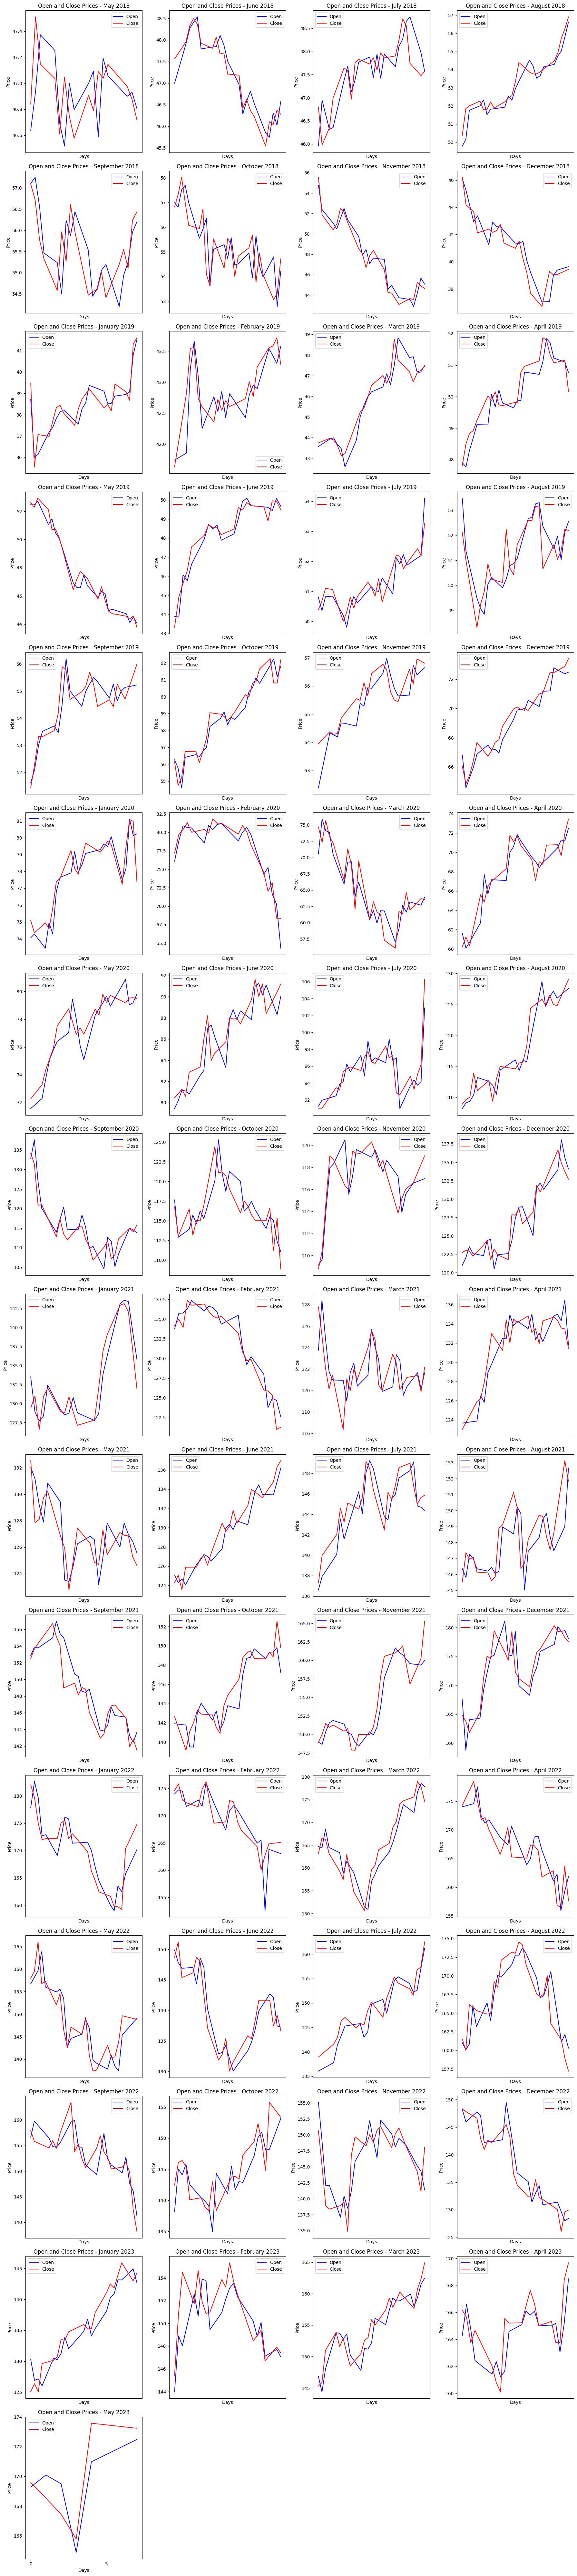

In [152]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Group data by month
grouped_data = df.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')
    ax.plot(days, group['close'], color='red', label='Close')
    ax.set_title(f"Open and Close Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

##### Using a correlation matrix to figure out which features are best for analyzing the data

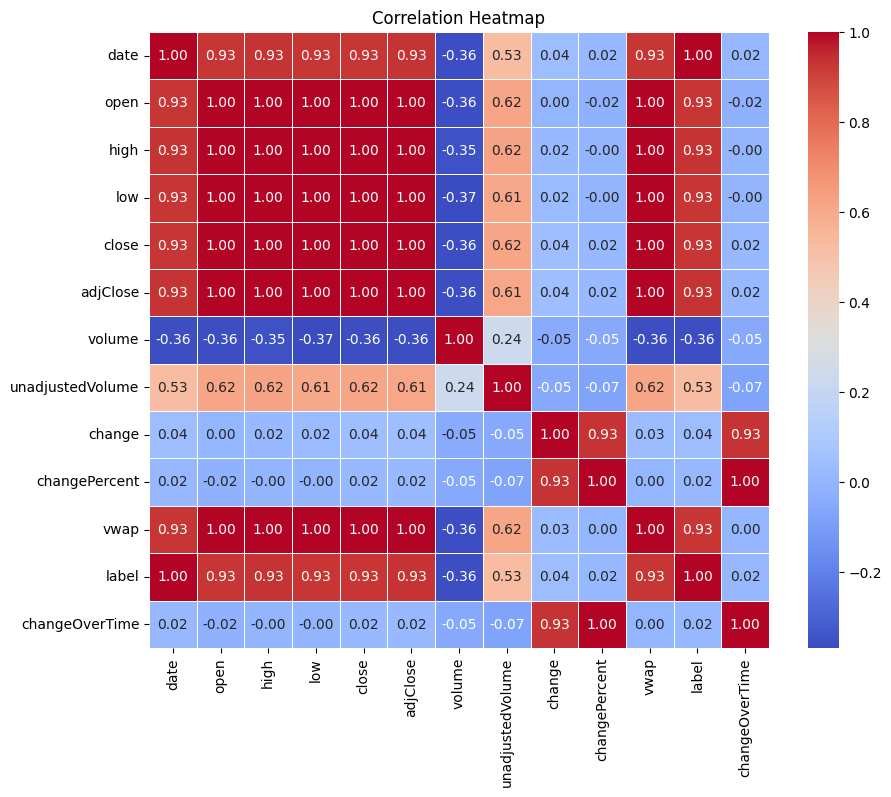

Correlation with Target Variable:
open                1.000000
high                0.999682
vwap                0.999622
low                 0.999616
close               0.999173
adjClose            0.999122
date                0.929712
label               0.929712
unadjustedVolume    0.619049
volume              0.359154
changePercent       0.020767
changeOverTime      0.020767
change              0.001840
Name: open, dtype: float64
Best Features to Analyze the Data:
['high', 'vwap', 'low']


In [153]:
# Convert 'Date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Parse the dates using dateutil.parser.parse()
df['label'] = df['label'].apply(parser.parse)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)

# Set the title
ax.set_title('Correlation Heatmap')

# Display the heatmap
plt.show()

# Select the target variable
target_variable = 'open'

# Calculate the correlation between each feature and the target variable
correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)

# Print the correlation with the target variable
print("Correlation with Target Variable:")
print(correlation_with_target)

# Select the top-k features with the highest absolute correlation coefficients
k = 3
best_features = correlation_with_target[1:k+1].index.tolist()

# Print the best features
print("Best Features to Analyze the Data:")
print(best_features)

Conclusions
 - For featurs with strong correlation with the prediction ('open') feature we will assume that they will be the most important features to affect and contribute our modeling of the data set in the next part. Particularly, the features '' and '', that we can see from the heatmap. 
 - We can also see a very strong correlation between features such as 'ChangePercent' and 'ChangeOverTime'. That is because they're basically a manipulation of the same feature ('Change'). In our PreProcessing part, we'll reduce the number of features to lower the complexity of our ML module.

# Preprocessing  

Now, we'll deep dive into the data and try to figure out how to deal with outliers, if the data is standardized, how to deal with missing data, how to compute categorial features into our models (dummy variables), addition of new features if needed and trying to reduce the dimensionality of the data to make our models less complex while explaining as much of the dataset's variation as possible.

We want to see the affect on the opening price by percentiles, so we'll work on the log of the price as our predicted value.

In this part we'll also divide our dataset into train data and test data randomly. We're taking this course of action so we can see how well our unsupervised modules preform at making opening prices predictions. 

* צריך להוסיף כאן לדאטה עמודה של לוג המחיר שאותו אנחנו רוצים לחזות (לא חייבים עדיין להוריד את העמודה של המחיר הרגיל, אפשר לחכות לאחרי שנחלק לסט אימון וסט מבחן)

In [154]:
df['log_price'] = np.log(df['open'])
df.drop('open', axis=1, inplace=True)

Spliting the data into train data and test data for our prediction

In [201]:
#test_data, train_data = train_test_split(df.copy(), test_size = 0.8, random_state= 42, shuffle=True)
train_data = df.iloc[:int(len(df) * 0.9)]
test_data = df.iloc[int(len(df) * 0.9):]

Removing the prediction feature - log_opening_price, from the test dataset, and save it as a new variable.
We do this in order to compare our results of the prediction log_opening_price to the actual log_opening_price of the test dataset at the end of the Modeling section. 

In [202]:
actual_test_log_price = pd.DataFrame(test_data["log_price"])
test_data.drop("log_price", axis=1, inplace=True)
train_data.shape

(1132, 13)

The dataset that we chose randomly has  observations and  features. Therefore, because it's relatively big, this train dataset is indeed representative and canhelp us make strong predictions with regards to the opening price of the stock in the future (if it will rise, fall or keep a relatively stable price inside a "safety zone" that will be determind later on).

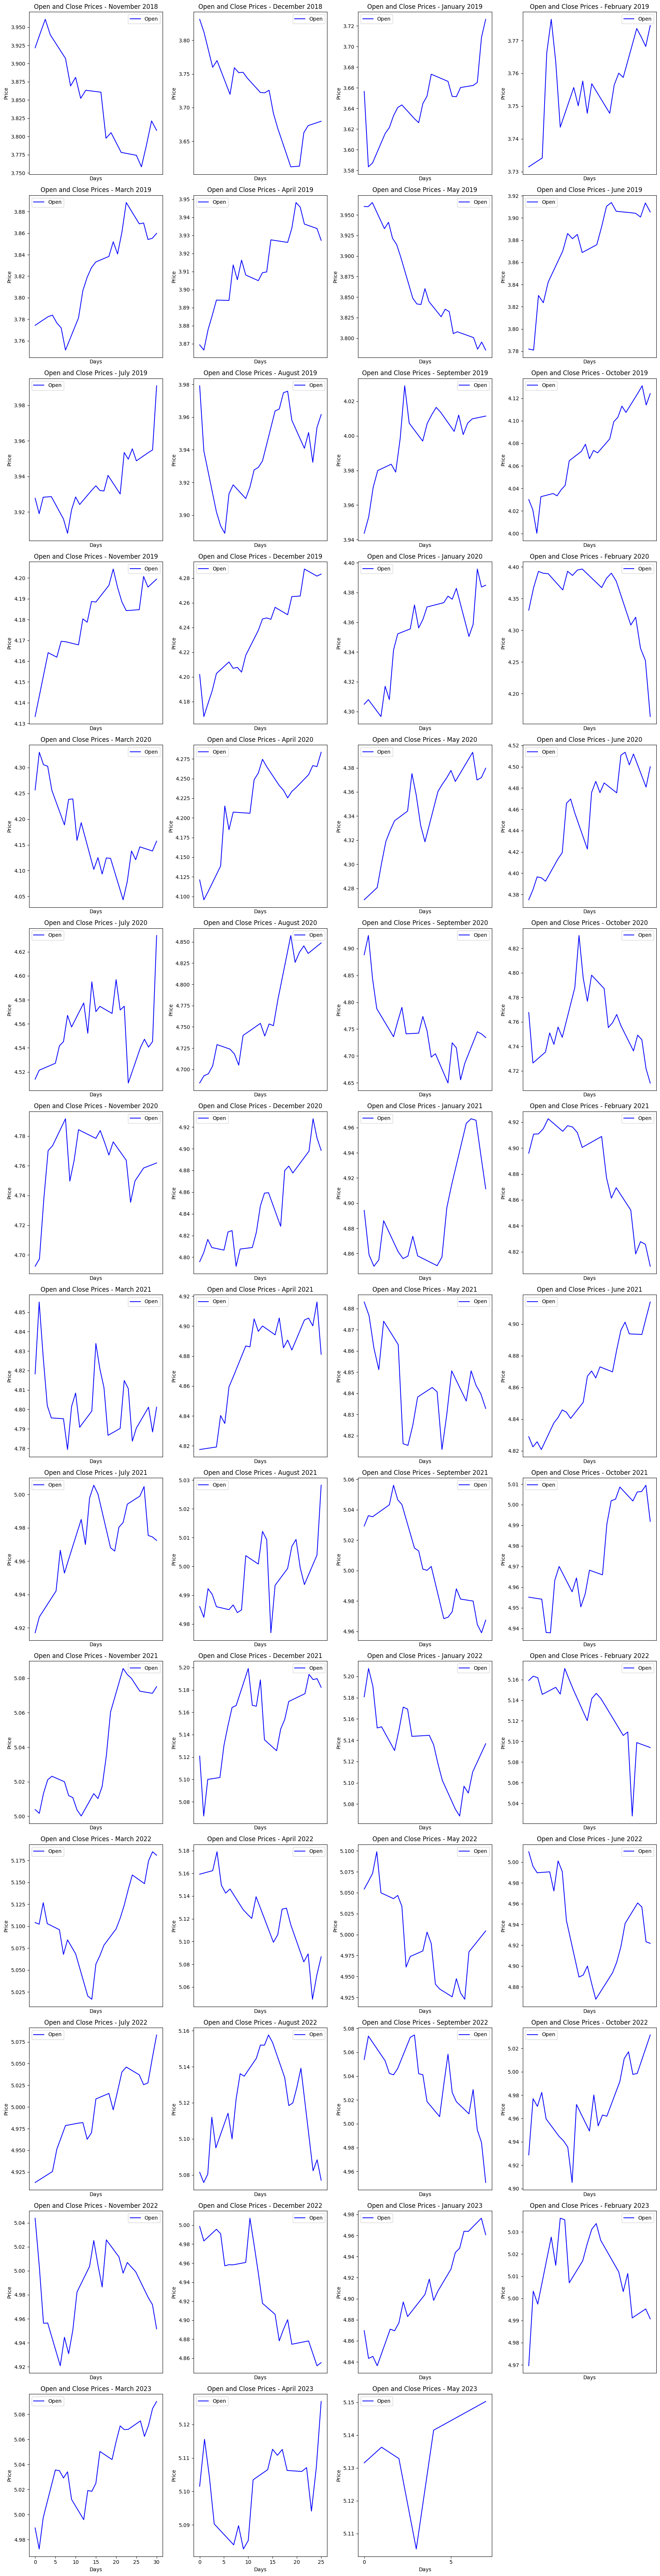

In [197]:
# Convert 'date' column to datetime type
train_data['date'] = pd.to_datetime(train_data['date'])

# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['log_price'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### Dealing with outliers

In the previous part we noticed some outliers in some of the features by reviewing the histograms and boxplots. Now we will handle them by removing extreme values that can have an unproportionate effect on our modules

Our way of doing that will be by changing the top and bottom percentiles, which we think will eliminate most of the unwanted values while not changing too many observations

Step 1: Identifying Outliers using np.diff

In [203]:
# Calculate the differences between consecutive open prices, excluding the first date
train_data['price_diff'] = np.diff(train_data['log_price'], prepend=train_data['log_price'].iloc[0])

# Calculate the lower and upper percentiles for outliers
lower_percentile = np.percentile(train_data['price_diff'], 1)
upper_percentile = np.percentile(train_data['price_diff'], 99)

# Identify outliers based on the percentiles
outliers = train_data.iloc[:-1][(train_data['price_diff'] < lower_percentile) | (train_data['price_diff'] > upper_percentile)]

Step 2: Dealing with Outliers using Moving Average

In [204]:
# Calculate the weighted moving average of log_price with a 4-observation window
weights = [0.05, 0.15, 0.25, 0.55]  # Example weights for the 4-observation window

window_size = 4
train_data['weighted_avg'] = np.nan

for i in range(window_size, len(train_data)):
    window_values = train_data.iloc[i - window_size:i, train_data.columns.get_loc('log_price')]
    
    if len(window_values) > 0:
        weighted_avg = np.sum(window_values * weights) / np.sum(weights)
        train_data.loc[i, 'weighted_avg'] = weighted_avg

# Update the log_price of outliers with the weighted moving average values
train_data.loc[outliers.index, 'log_price'] = train_data.loc[outliers.index, 'weighted_avg']

# Interpolate missing values in log_price
train_data['log_price'].interpolate(method='linear', inplace=True)

# Drop the 'weighted_avg' column
train_data.drop('weighted_avg', axis=1, inplace=True)

Viewing the changes:

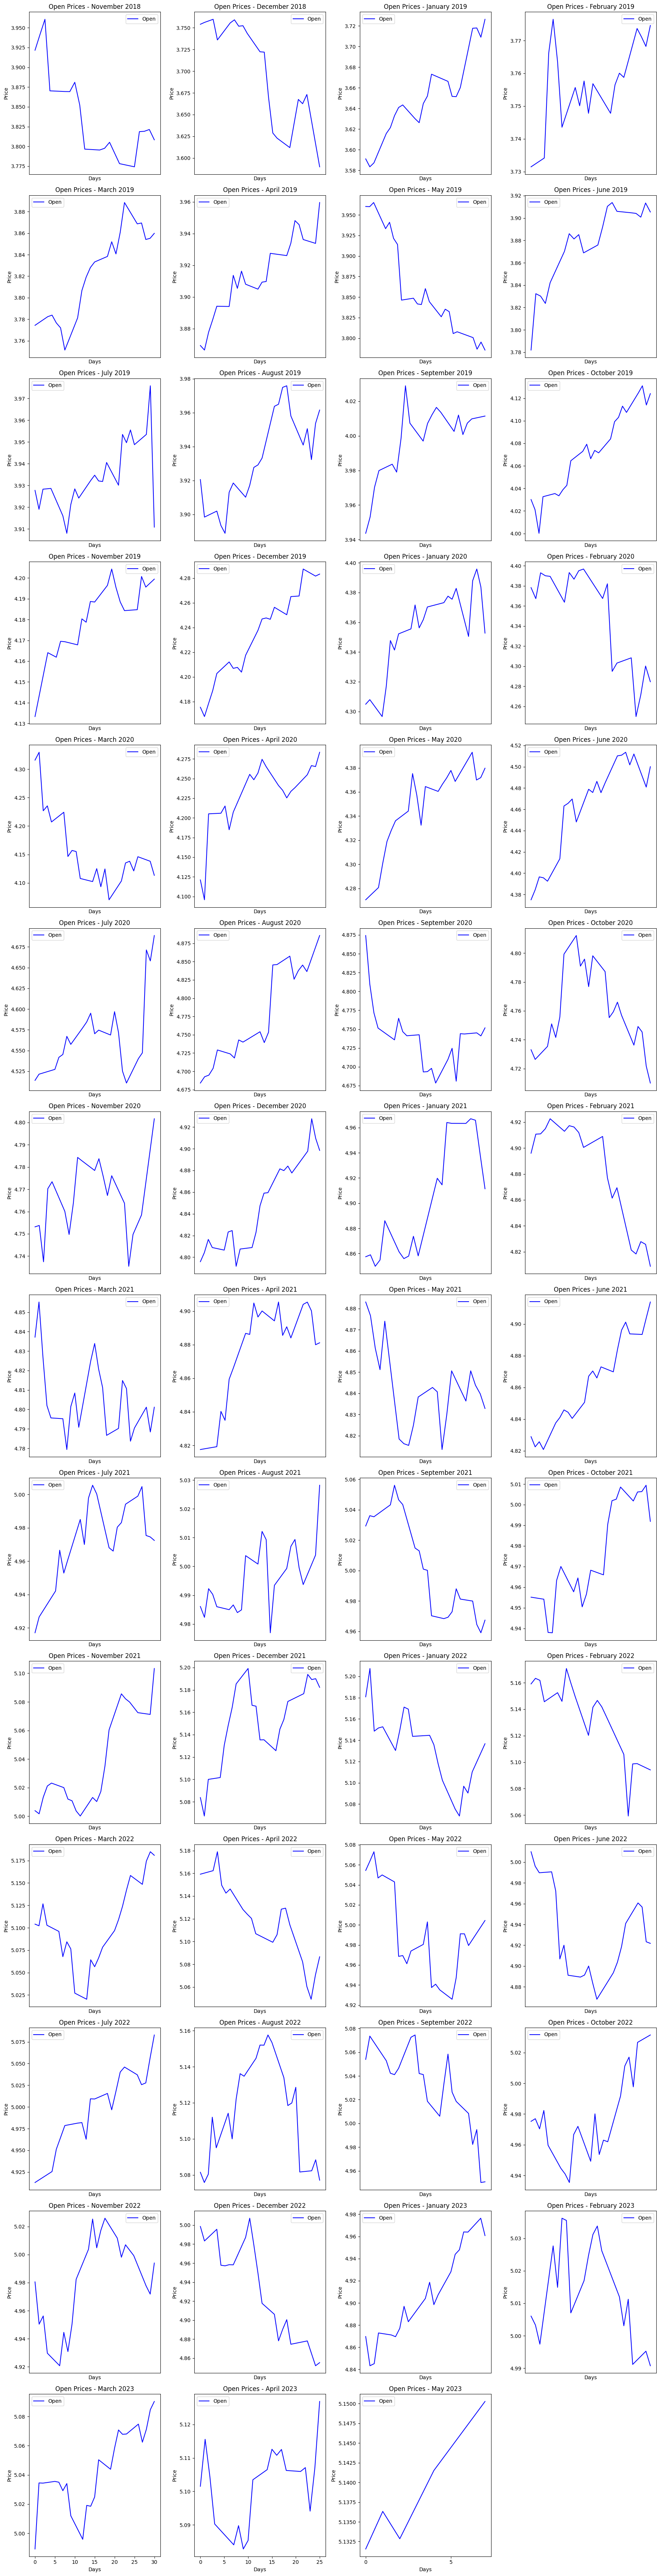

In [205]:
# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['log_price'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

As we can see by the plots, due to us 'flattening' the outliers, the open prices have a smaller range of values<br>As a result, the plots now have a 'smoother' line

In [94]:
# Assuming 'df' is your DataFrame and 'feature' is the column you want to analyze
# Calculate the z-score for the feature
z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())

# Define a threshold (e.g., 3) to identify outliers
threshold = 3

# Identify outliers based on the threshold
outliers = df[z_scores > threshold]

# Calculate the lower and upper percentiles excluding outliers
lower_percentile = np.percentile(df[feature][~(z_scores > threshold)], 1)
upper_percentile = np.percentile(df[feature][~(z_scores > threshold)], 99)

# Remove the top and bottom percentiles from the data
df_filtered = df[(df[feature] >= lower_percentile) & (df[feature] <= upper_percentile)]

# Print the filtered data
print("Filtered Data:")
print(df_filtered)

Filtered Data:
           date      high       low     close    adjClose     volume   
0    2023-05-08  173.8200  172.1100  173.2300  173.230000   20870258  \
1    2023-05-05  174.3000  170.7600  173.5700  173.570007  112900196   
2    2023-05-04  167.0400  164.3100  165.7900  165.789993   81225673   
3    2023-05-03  170.9200  167.1600  167.4500  167.449997   65126998   
4    2023-05-02  170.3500  167.5400  168.5400  168.539993   48425696   
...         ...       ...       ...       ...         ...        ...   
1253 2018-05-15   46.7675   46.2750   46.6100   44.605644   94780636   
1254 2018-05-14   47.3825   46.9650   47.0375   45.014744   82923888   
1255 2018-05-11   47.5150   46.8625   47.1475   45.120029  104448884   
1256 2018-05-10   47.5925   46.9125   47.5100   45.292290  111957156   
1257 2018-05-09   46.8500   46.3050   46.8400   44.653561   92844964   

      unadjustedVolume  change  changePercent    vwap      label   
0             20870258  0.7500       0.434833  173.0

### Dealing with overlaping features

As we can see from our data exploration, the data contains some overlaping features. In this section we'll drop unnecessary features. This will help lower the complexity of the ML modules we'll use later on while maintaining maximum explanatory power of the variable we want to predict in our models. 

The next function takes a categorial feature and turnes it into a set of dummy variables:

In [95]:
def Get_Dummies(feature, predict_feature, train_data, test_data):
    train_data = pd.get_dummies(train_data, prefix=[feature], columns = [feature], drop_first=True)
    ordered_cols = [x for x in train_data.columns if x not in[predict_feature]] + [predict_feature]
    train_data = train_data[ordered_cols]
    test_data = pd.get_dummies(test_data, prefix=[feature], columns = [feature], drop_first=True)
    return train_data, test_data

The following function converts numbers from scientific notation to regular notation:

* Adding the 'day', 'month' and 'year' categorical variables to the train data, then dropping the 'date' column

In [96]:
train_data['day'] = train_data['date'].dt.day
train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year
train_data = train_data.drop('date', axis=1)


* Adding the 'day', 'month' and 'year' categorical variables to the test data, then dropping the 'date' column

In [97]:
test_data['day'] = test_data['date'].dt.day
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data = test_data.drop('date', axis=1)

* Turning 'day', 'month' and 'year' into dummy variables

In [98]:
train_data, test_data = Get_Dummies('day', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('month', 'log_price', train_data, test_data)
train_data, test_data = Get_Dummies('year', 'log_price', train_data, test_data)

In [99]:
train_data.shape, test_data.shape

((996, 60), (251, 60))

After these changes, let's see how our train dataset looks like:

In [101]:
train_data_features, test_data_features = np.array(train_data.columns), np.array(test_data.columns)
print(f"Train data features: {train_data_features}\n\n Test data features: {test_data_features}")

Train data features: ['high' 'low' 'close' 'adjClose' 'volume' 'unadjustedVolume' 'change'
 'changePercent' 'vwap' 'label' 'changeOverTime' 'open_log' 'close_log'
 'day_2' 'day_3' 'day_4' 'day_5' 'day_6' 'day_7' 'day_8' 'day_9' 'day_10'
 'day_11' 'day_12' 'day_13' 'day_14' 'day_15' 'day_16' 'day_17' 'day_18'
 'day_19' 'day_20' 'day_21' 'day_22' 'day_23' 'day_24' 'day_25' 'day_26'
 'day_27' 'day_28' 'day_29' 'day_30' 'day_31' 'month_2' 'month_3'
 'month_4' 'month_5' 'month_6' 'month_7' 'month_8' 'month_9' 'month_10'
 'month_11' 'month_12' 'year_2019' 'year_2020' 'year_2021' 'year_2022'
 'year_2023' 'log_price']

 Test data features: ['high' 'low' 'close' 'adjClose' 'volume' 'unadjustedVolume' 'change'
 'changePercent' 'vwap' 'label' 'changeOverTime' 'open_log' 'close_log'
 'log_price' 'day_2' 'day_3' 'day_4' 'day_5' 'day_6' 'day_7' 'day_8'
 'day_9' 'day_10' 'day_11' 'day_12' 'day_13' 'day_14' 'day_15' 'day_16'
 'day_17' 'day_18' 'day_19' 'day_20' 'day_21' 'day_22' 'day_23' 'day_24'
 'da

Before dealing with dimentionality reduction and normalization, we will devide the dataset into x train, y train and x test:

* חלוקה לסך המשתנים ולמשתנה לחיזוי עבור סט האימון וסט המבחן

In [90]:
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:].values

### Dealing with Normalization

In our data, some of the features are normalized and some aren't. Data normalization is the method of organizing data to appear similar across all records and fields. Performing so always results in getting higher quality data and better results. This process basically includes eliminating unstructured data and duplicates in order to ensure logical data storage.

### Dimentionality reduction process


### Forward Selection

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

our "punishment" method in which we'll evaluate the number of features will be Mallow's C_p.
In statistics, Mallows's Cp is used to assess the fit of a regression model that has been estimated using ordinary least squares. It is applied in the context of model selection, where a number of predictor variables are available for predicting some outcome, and the goal is to find the best model involving a subset of these predictors. A small value of Cp means that the model is relatively precise.

$ C_p= MSE+2\frac{d+1}{n}\hat{\sigma}^2$ <br><br>
Where : $ \hat{\sigma}^2 = \frac{RSS_{all features}}{n-\#features-1} $,   and $\#features$ is the number of all features

We'll evaluate our Forward Feature Selection using Mallow's C_p

![https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg](https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg)

Feature Selection with Linear Regression:

In [104]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    reg  = LinearRegression()
    reg.fit(X, y)
    y_preds = reg.predict(X)
    MSE = mean_squared_error(y, y_preds)
    RSS = MSE * len(X)
    sigma_hat_squared = RSS / (len(X) - len(X[1]) - 1)
    return sigma_hat_squared

In [105]:
def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    reg  = LinearRegression() 
    reg.fit(X, y)
    preds = reg.predict(X)
    MSE = mean_squared_error(y, preds)
    d = X.shape[1]
    n = len(X)
    Cp = MSE + (2* sigma_hat_squared * (d + 1)) / n
    return Cp

In [106]:
def add_feature(X: np.array ,y: np.array ,current_features, sigma_hat_squared: float):
    best_score = np.inf
    num_of_features = X.shape[1]
    for i in range(num_of_features):
        if i in current_features:
            continue
        current_features_copy_added_feature = current_features.copy()
        current_features_copy_added_feature.append(i)
        current_features_copy_added_feature.sort()
        current_Cp = get_mallows_cp_score(X[:, current_features_copy_added_feature], y, sigma_hat_squared) 
        if (current_Cp <= best_score):
            best_score = current_Cp
            best_features_lst = current_features_copy_added_feature
      
    return {'features':sorted(best_features_lst),'score':best_score}  

In [107]:
def forward_selection(X: np.array, y: np.array):
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst, 'g')
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

In [108]:
best_features_list = forward_selection(X_train_normalize, y_train)
print(f'number of selected features by forward: {len(best_features_list)}')
print(f'best features by forward: {best_features_list}')

NameError: name 'X_train_normalize' is not defined

In [ ]:
print(f"The features that remain in our analysis after the forward selection methods: {list(train_data_features[best_features_list])}")

### PCA 
The function will return the minimal group of components, which explain more than (100*0.95)% of the variance.

In [ ]:
def get_principal_components(X: np.array) -> np.array:
    pca = PCA(n_components = X.shape[1], whiten=True)
    pca.fit_transform(X)
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Cumulitive Explained variance per eigenvector")
    plt.xlabel("number of features")
    plt.ylabel("percentage")
    plt.show()

    pca = PCA(0.95, whiten=True)
    data = pca.fit_transform(X)
    print("For explained variance:", 0.99, "number of components/dimentions:", data.shape[1])
    return pca.components_

In [ ]:
best_components_list = get_principal_components(X_train_normalize)

### Comparison between forward selection and PCA

In [ ]:
# calculate the test MSE for each reduced dataset
X_forward_reduced_train = X_train_normalize[:, best_features_list]

# get components based on train set:
X_pca_train = np.dot(X_train_normalize, best_components_list.T)
#x_pca_test = np.dot(X_test, train_components.T)

#### Results
Using these new datasets, we will now print the train mse of each model:

In [ ]:
Lreg_forward = LogisticRegression().fit(X_forward_reduced_train, y_train)
Lreg_pca = LogisticRegression().fit(X_pca_train, y_train)

reg_forward_predict_train = Lreg_forward.predict(X_forward_reduced_train)
#reg_forward_predict_test = reg_forward.predict(x_forward_reduced_test)
reg_pca_predict_train = Lreg_pca.predict(X_pca_train)
#reg_pca_predict_test = reg_pca.predict(x_pca_test)

train_mse_forward = mean_squared_error(y_train, reg_forward_predict_train)
#test_mse_forward = mean_squared_error(y_test, reg_forward_predict_test)
train_mse_pca = mean_squared_error(y_train, reg_pca_predict_train)
#test_mse_pca = mean_squared_error(y_test, reg_pca_predict_test)

print(f'MSE train - PCA: {round(train_mse_pca,4)}')
#print(f'MSE test - PCA: {round(test_mse_pca,4)}')
print(f'MSE train - forward: {round(train_mse_forward,4)}')
#print(f'MSE test - forward: {round(test_mse_forward,4)}')

In [ ]:
X_train_before_split = X_forward_reduced_train
y_train_before_split = y_train.copy()
data_reduction = data.iloc[:, best_features_list]
X_Test = X_test_normalize[:, best_features_list]

## Label Definition